In [ ]:
import pickle
import pandas as pd
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score


import torch
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader, Dataset

from __future__ import print_function, division



import time
import os
import copy


sns.set(style="darkgrid", font_scale=1.4)

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)
torch.backends.cudnn.deterministic = True

In [ ]:
from google.colab import drive # Настроим доступ к данным
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
!unzip -q /content/gdrive/MyDrive/Colab_Notebooks/DATA/journey-springfield.zip

In [ ]:
!ls train
!ls testset

simpsons_dataset
testset


In [ ]:
from pathlib import Path
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

In [ ]:
train_val_files = list(TRAIN_DIR.rglob('*.jpg')) # Проверим, что данные загружаются и что в заявленном колл-ве
test_files = list(TEST_DIR.rglob('*.jpg'))
print(len(train_val_files)) #=> 20933
print(len(test_files)) #=> 991

20933
991


Ниже мы исспользуем враппер над датасетом для удобной работы.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet

Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следует привести их к одному размеру (это делает метод  _prepare_sample).

In [ ]:
transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),    
        transforms.RandomResizedCrop(224),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        transforms.RandomAutocontrast(),        
        transforms.RandomVerticalFlip(p=0.5),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False): # Функция для просмотра
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
train_val_labels = [path.parent.name for path in train_val_files] # Разделим данные на train и valid , 75% и 25% соотвественно
train_files, val_files = train_test_split(train_val_files, test_size=0.20, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

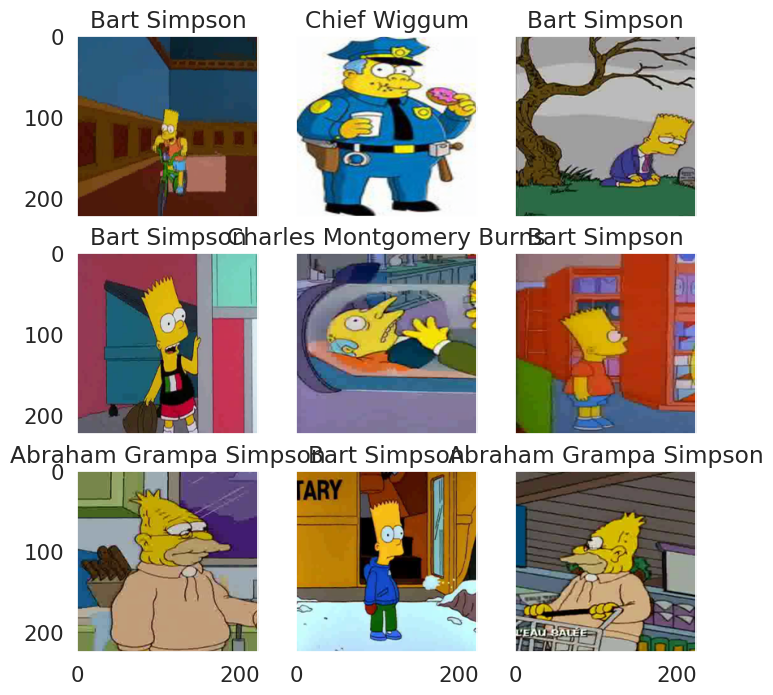

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
# Посмотрим на наши данные

Создадим сеть

In [ ]:
class SimpleCnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(512 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, n_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

Зададим основные функции

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer): # Обучение
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    model.train() # переводим модель в режим обучения

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, dim=1) 
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.float() / processed_data 
    return train_loss, train_acc


In [ ]:
def eval_epoch(model, val_loader, criterion):  # Прогноз
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    # создание DataLoader для обучающего и валидационного датасетов
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # история метрик обучения
    history = []
    
    # шаблон для логгирования
    log_template = "Epoch {ep:03d} train_loss: {t_loss:.4f} val_loss {v_loss:.4f} train_acc {t_acc:.4f} val_acc {v_acc:.4f}"
    
    # определение функции потерь и оптимизатора
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    # прогон по эпохам
    for epoch in range(epochs):
        # обучение на тренировочном датасете
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
        
        # валидация на валидационном датасете
        val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        
        # добавление метрик в историю
        history.append((train_loss, train_acc, val_loss, val_acc))
        
        # логгирование прогресса
        print(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
        
    return history


In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    

Запустим Обучение

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=15, batch_size=64)

Epoch 001 train_loss: 1.9362 val_loss 1.1620 train_acc 0.5097 val_acc 0.6862
Epoch 002 train_loss: 0.9547 val_loss 0.7876 train_acc 0.7398 val_acc 0.7798
Epoch 003 train_loss: 0.6050 val_loss 0.5366 train_acc 0.8321 val_acc 0.8479
Epoch 004 train_loss: 0.3872 val_loss 0.4320 train_acc 0.8912 val_acc 0.8856
Epoch 005 train_loss: 0.2327 val_loss 0.3915 train_acc 0.9364 val_acc 0.8932
Epoch 006 train_loss: 0.1730 val_loss 0.4027 train_acc 0.9503 val_acc 0.8956
Epoch 007 train_loss: 0.1310 val_loss 0.3690 train_acc 0.9624 val_acc 0.9004
Epoch 008 train_loss: 0.1002 val_loss 0.3878 train_acc 0.9721 val_acc 0.9049
Epoch 009 train_loss: 0.0733 val_loss 0.3509 train_acc 0.9797 val_acc 0.9114
Epoch 010 train_loss: 0.0633 val_loss 0.3748 train_acc 0.9796 val_acc 0.9150
Epoch 011 train_loss: 0.0788 val_loss 0.3679 train_acc 0.9752 val_acc 0.9126
Epoch 012 train_loss: 0.0668 val_loss 0.3413 train_acc 0.9801 val_acc 0.9152
Epoch 013 train_loss: 0.0529 val_loss 0.3649 train_acc 0.9837 val_acc 0.9138

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

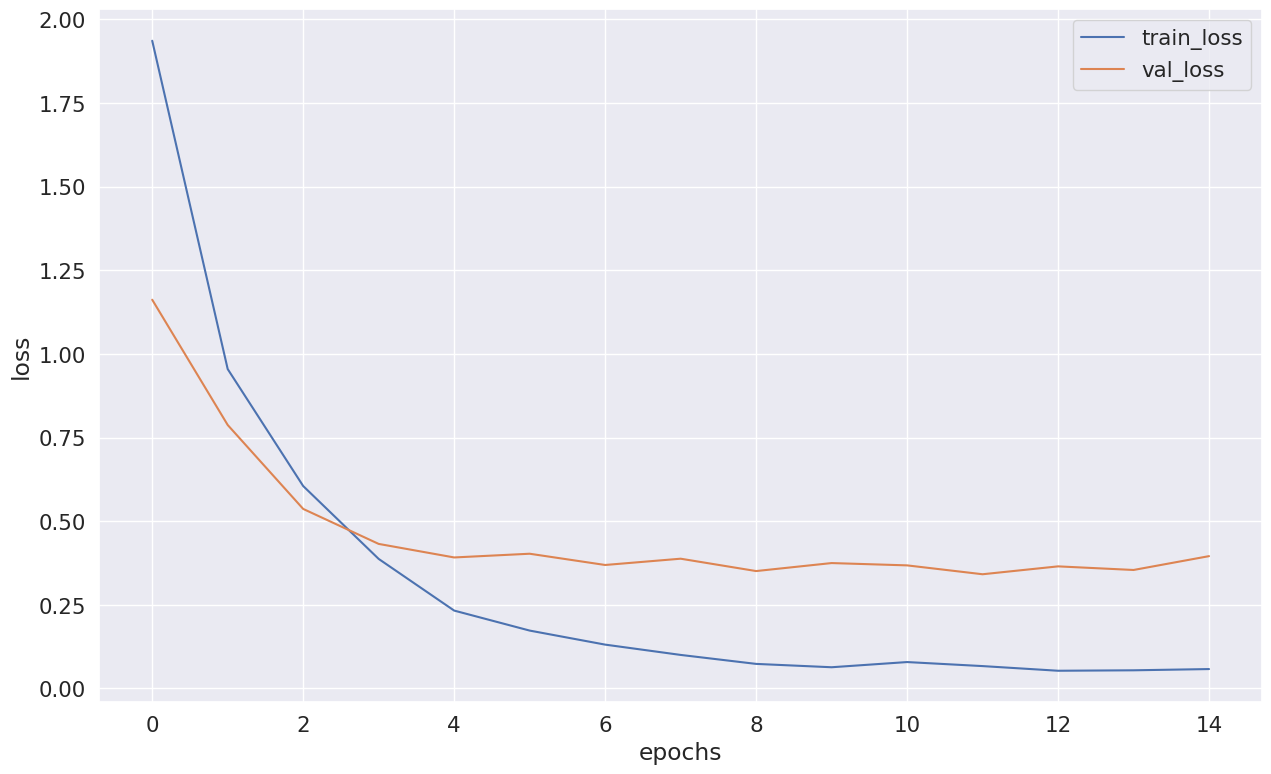

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

0.9

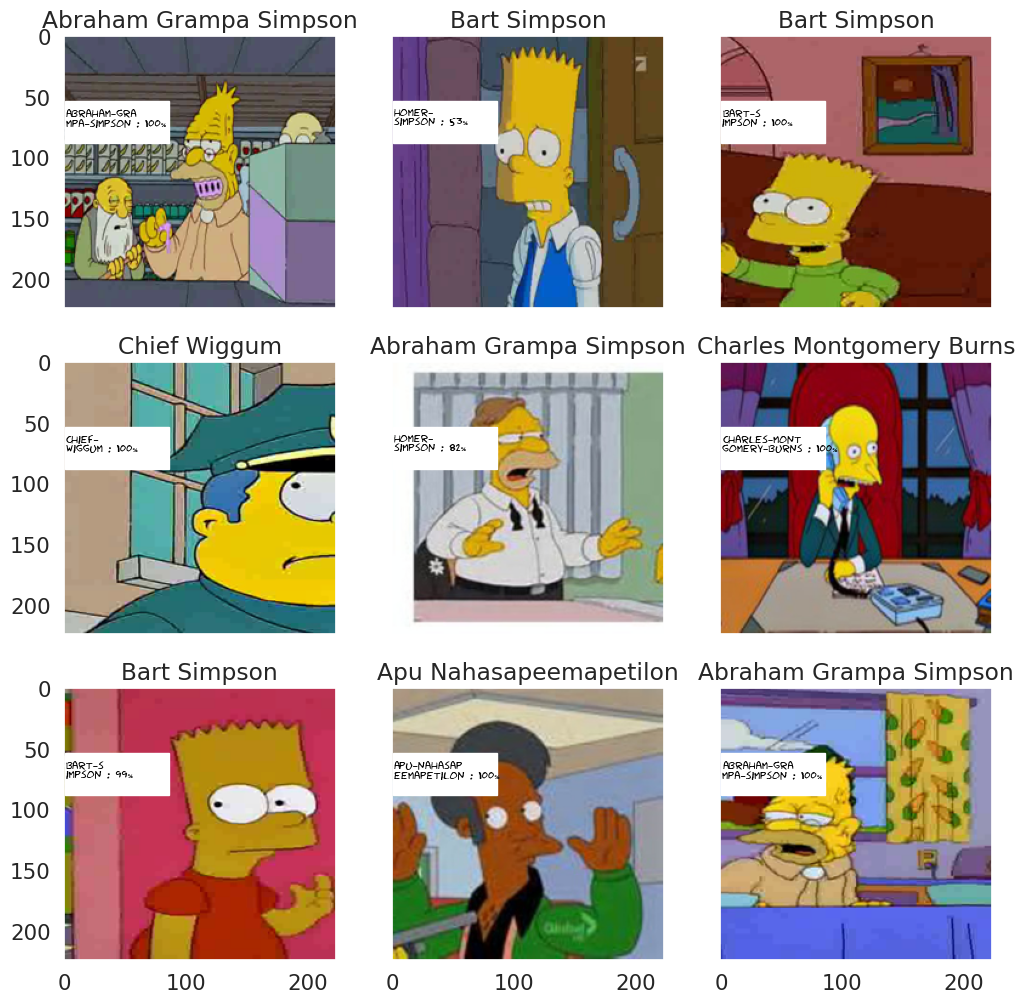

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd
# my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('gdrive/MyDrive/Colab_Notebooks/Studying/simple_cnn_baseline_01.csv', index=False)

Наш score на Kaggle

---



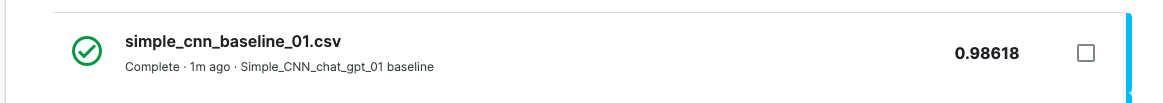